Cosine Similarity timing
===

Timing a few different methods for computing cosine similarity of one vector against a large set of other vectors. This can be used for example in retrieval augmentation systems based on embeddings. The faster approach is to use an approximate algorithm; this approach is exact, at the cost of additional computation time.

See https://github.com/openai/openai-python/blob/main/openai/embeddings_utils.py#L139

In [44]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

In [24]:
scipy.spatial.distance.cdist(
    np.array([[1, 1, 1]]),
    np.array([[1, 1, 1], [1, 1, 2]]),
    metric="cosine",
)

array([[0.        , 0.05719096]])

In [23]:
# Note: cosine similarity is just 1 - cosine distance.
1 - scipy.spatial.distance.cosine(np.array([1, 1, 1]), np.array([1, 1, 2]))

0.9428090415820632

In [6]:
query = np.random.random(size=512)
query.shape

(512,)

In [7]:
db = np.random.random(size=(48, 512))
db.shape

(48, 512)

In [11]:
scipy.spatial.distance.cosine(query, db[0, :])

0.26056964768464796

In [17]:
scipy.spatial.distance.cdist(query.reshape((1, 512)), db, metric="cosine")

array([[0.26056965, 0.25271161, 0.2367958 , 0.24536739, 0.24314732,
        0.24599402, 0.23657472, 0.24084664, 0.23875645, 0.23218784,
        0.24351143, 0.24897073, 0.24883449, 0.25433491, 0.23551029,
        0.25644906, 0.24845474, 0.26725598, 0.25635885, 0.23760381,
        0.24285746, 0.25217799, 0.24486448, 0.23510934, 0.27505571,
        0.24729091, 0.23321341, 0.21602993, 0.25784542, 0.24507379,
        0.24443943, 0.25102161, 0.24826339, 0.23725274, 0.25438084,
        0.2354086 , 0.24683656, 0.24541899, 0.24124376, 0.26366446,
        0.24585097, 0.23890764, 0.26593915, 0.23328155, 0.23562616,
        0.24607202, 0.26223598, 0.24549929]])

In [43]:
def time_cossim(embedding_size=512, db_size=1000):
    d = {
        "embedding_size": embedding_size,
        "db_size": db_size,
    }
    query = np.random.random(size=(1, embedding_size))
    db = np.random.random(size=(db_size, embedding_size))

    s = time.time()
    scipy.spatial.distance.cdist(query, db, metric="cosine")
    d["cdist_time"] = time.time() - s

    s = time.time()
    query_1d = query[0, :]
    res = np.zeros(db_size)
    for i in range(db_size):
        res[i] = scipy.spatial.distance.cosine(query_1d, db[i, :])
    d["cosine_loop_numpy_time"] = time.time() - s

    s = time.time()
    res = [scipy.spatial.distance.cosine(query_1d, db[i, :]) for i in range(db_size)]
    d["cosine_loop_comp_time"] = time.time() - s
    return d


time_cossim()

{'embedding_size': 512,
 'db_size': 1000,
 'cdist_time': 0.0013499259948730469,
 'cosine_loop_numpy_time': 0.01905202865600586,
 'cosine_loop_comp_time': 0.011445045471191406}

In [91]:
n_trials = 50
ds = []
for embedding_size in tqdm([512, 968, 1024, 1536]):
    for db_size in [100, 1000, 10000, 100000]:
        for i in range(n_trials):
            d = time_cossim(embedding_size=embedding_size, db_size=db_size)
            d["trial"] = i
            ds.append(d)
len(ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:12<00:00, 138.24s/it]


800

In [92]:
df = pd.DataFrame(ds)
df.shape

(800, 6)

In [93]:
agg_ds = []
for index, group in df.groupby(["embedding_size", "db_size"]):
    agged = group.agg([np.median, lambda d: d.quantile(0.9), lambda d: d.quantile(0.1)])
    agged = agged.set_axis(["median", "high", "low"], axis=0)
    d = {
        "embedding_size": agged.embedding_size.iloc[0],
        "db_size": agged.db_size.iloc[0],
    }
    for method in cossim_methods:
        d[f"{method}_median"] = agged.loc["median", method]
        d[f"{method}_low"] = agged.loc["low", method]
        d[f"{method}_high"] = agged.loc["high", method]
    agg_ds.append(d)
agg_df = pd.DataFrame(agg_ds)
agg_df.shape

(16, 11)

In [94]:
# compute time scales only modestly with embedding size
# it's all about the size of the database
# of the three methods, computing the cdist is clearly the fastest
agg_df

,embedding_size,db_size,cdist_time_median,cdist_time_low,cdist_time_high,cosine_loop_numpy_time_median,cosine_loop_numpy_time_low,cosine_loop_numpy_time_high,cosine_loop_comp_time_median,cosine_loop_comp_time_low,cosine_loop_comp_time_high
0,512.0,100.0,0.000096,0.000080,0.000140,0.000993,0.000880,0.001300,0.000992,0.000877,0.001315
1,512.0,1000.0,0.000773,0.000755,0.000827,0.008699,0.008592,0.009315,0.008685,0.008583,0.009444
2,512.0,10000.0,0.007694,0.007602,0.008060,0.089121,0.086913,0.090791,0.088603,0.086627,0.091106
3,512.0,100000.0,0.085896,0.082920,0.091689,0.902907,0.893452,0.916733,0.898963,0.890630,0.909455
4,968.0,100.0,0.000162,0.000161,0.000173,0.000929,0.000913,0.000957,0.000927,0.000908,0.000953
5,968.0,1000.0,0.001619,0.001582,0.001754,0.009511,0.009266,0.009790,0.009530,0.009249,0.009845
6,968.0,10000.0,0.016190,0.015892,0.016634,0.095351,0.093832,0.096229,0.095240,0.094229,0.096633
7,968.0,100000.0,0.178575,0.170591,0.204396,0.949317,0.940351,0.963200,0.948642,0.937030,0.962121
8,1024.0,100.0,0.000175,0.000171,0.000197,0.000939,0.000922,0.001024,0.000940,0.000917,0.001013
9,1024.0,1000.0,0.001708,0.001684,0.001780,0.009359,0.009235,0.009895,0.009410,0.009249,0.010207


In [95]:
sdf = agg_df[agg_df.embedding_size == 1536]
sdf

,embedding_size,db_size,cdist_time_median,cdist_time_low,cdist_time_high,cosine_loop_numpy_time_median,cosine_loop_numpy_time_low,cosine_loop_numpy_time_high,cosine_loop_comp_time_median,cosine_loop_comp_time_low,cosine_loop_comp_time_high
12,1536.0,100.0,0.000263,0.000261,0.000270,0.000987,0.000976,0.001018,0.000977,0.000968,0.001008
13,1536.0,1000.0,0.002610,0.002588,0.002732,0.009917,0.009793,0.010496,0.009910,0.009749,0.010944
14,1536.0,10000.0,0.026310,0.026059,0.027215,0.101099,0.099854,0.103800,0.101240,0.099614,0.103961
15,1536.0,100000.0,0.294039,0.277531,0.346399,1.027146,1.010957,1.054374,1.023777,1.007066,1.169910


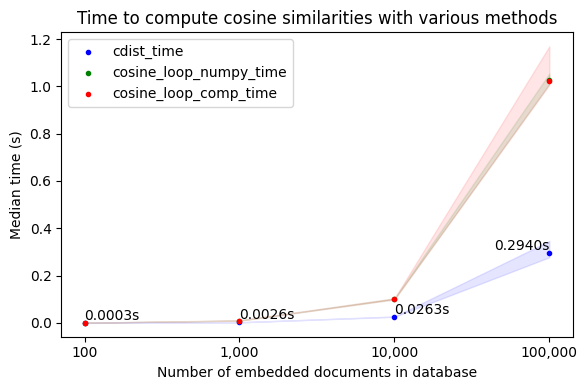

In [102]:
# note: confidence intervals are the 10-90th percentile of timings
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

x = sdf.db_size
xs = list(range(len(x)))
ax.set_xticks(xs, labels=[f"{v:,.0f}" for v in x])

for cossim_method, color in zip(cossim_methods, ["blue", "green", "red"]):
    ax.scatter(xs, sdf[f"{cossim_method}_median"], color=color, marker=".", label=cossim_method)
    ax.fill_between(xs, sdf[f"{cossim_method}_low"], sdf[f"{cossim_method}_high"], color=color, alpha=0.1)
    if cossim_method == "cdist_time":
        for i, value in enumerate(sdf[f"{cossim_method}_median"]):
            ax.text(i, value, f"{value:.4f}s", ha="left" if i != len(xs) - 1 else "right", va="bottom")

ax.legend()
ax.set_title("Time to compute cosine similarities with various methods")
ax.set_ylabel("Median time (s)")
ax.set_xlabel("Number of embedded documents in database")

fig.tight_layout()
plt.show()